In [7]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_cst_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [8]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(50, 90, 41)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:41,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((41,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [9]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [10]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [11]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_63426/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [15]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     522     0:01.1
2     1002    0:02.2
3     1470    0:03.1
20    8604    0:15.5
40    14664   0:26.1
60    20364   0:36.5
80    26181   0:47.6
100   31899   0:58.0
120   37644   1:08.4
140   43548   1:19.2
160   49344   1:29.7
180   55293   1:40.5
200   61161   1:51.4
220   66966   2:01.9
240   72696   2:12.5
260   78522   2:23.2
280   84234   2:33.7
300   89919   2:44.1
320   95538   2:54.4
340   101259   3:04.9
360   106935   3:15.4
380   112815   3:26.0
400   118536   3:36.4
420   124038   3:46.6
440   129489   3:56.5
460   135366   4:07.1
480   141021   4:17.5
500   146574   4:27.6
520   152379   4:38.2
540   157980   4:48.3
560   163890   4:59.0
580   169503   5:09.2
600   175161   5:19.4
620   180669   5:29.3
640   186279   5:39.7
660   192195   5:50.6
680   198090   6:01.2
700   204102   6:12.4
720   209793   6:22.6
740   215661   6:33.2
760   221394   6

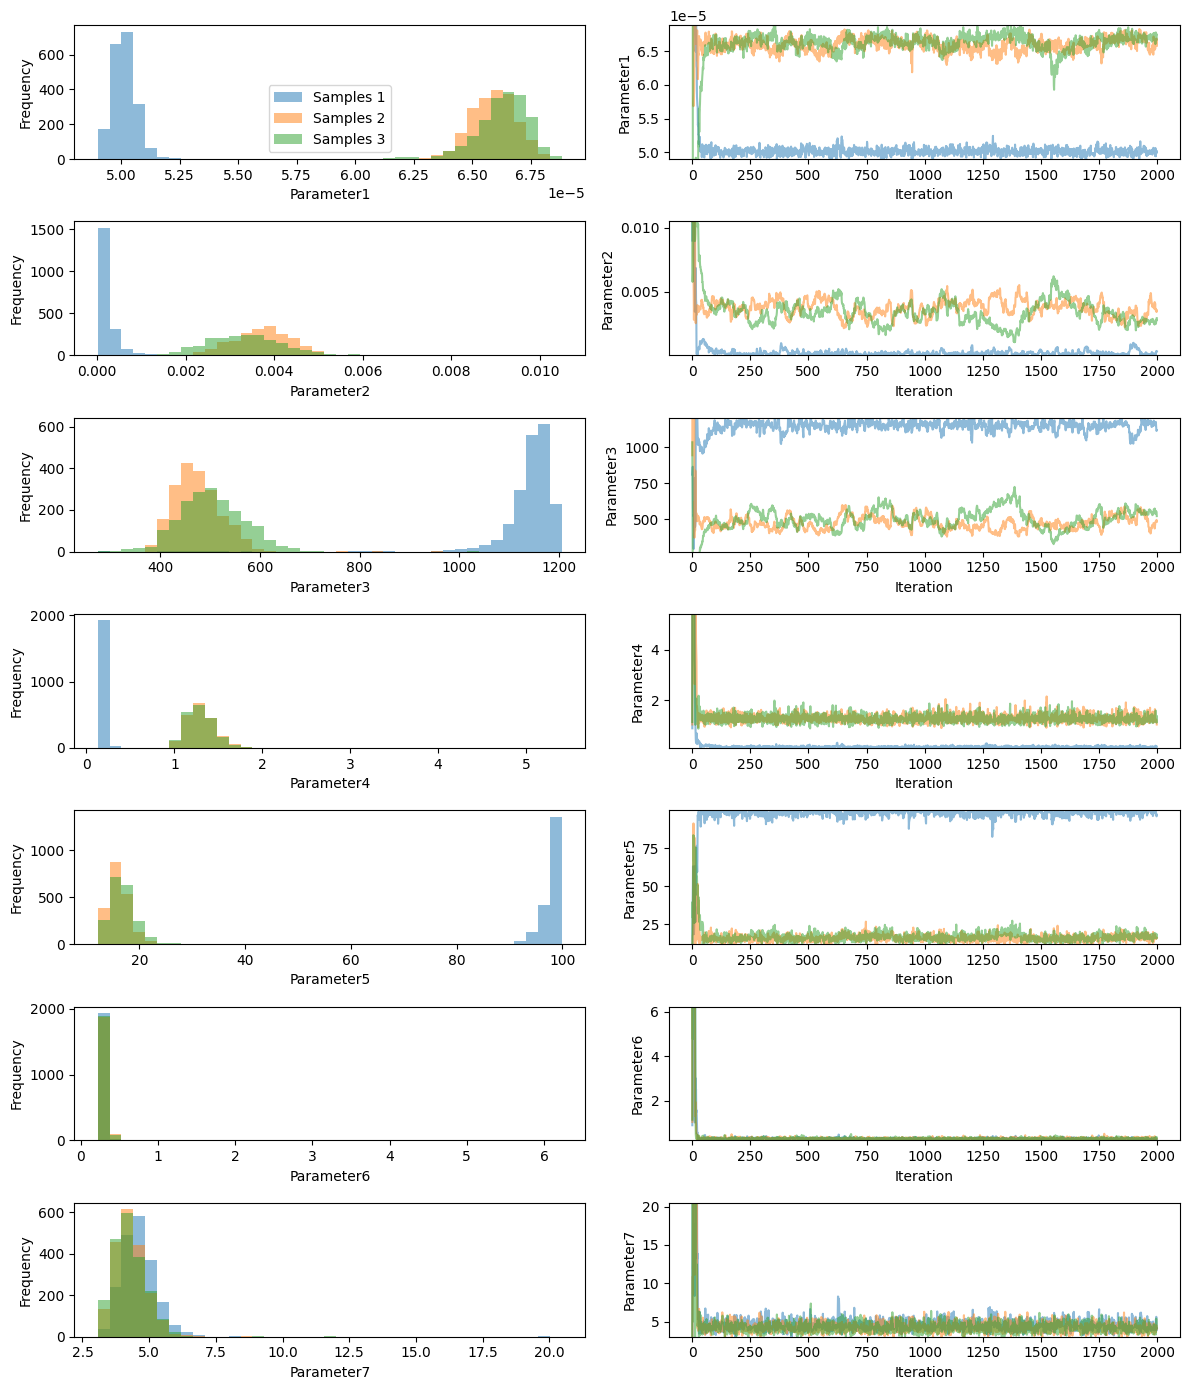

In [16]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [17]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


NameError: name 'AllChains' is not defined

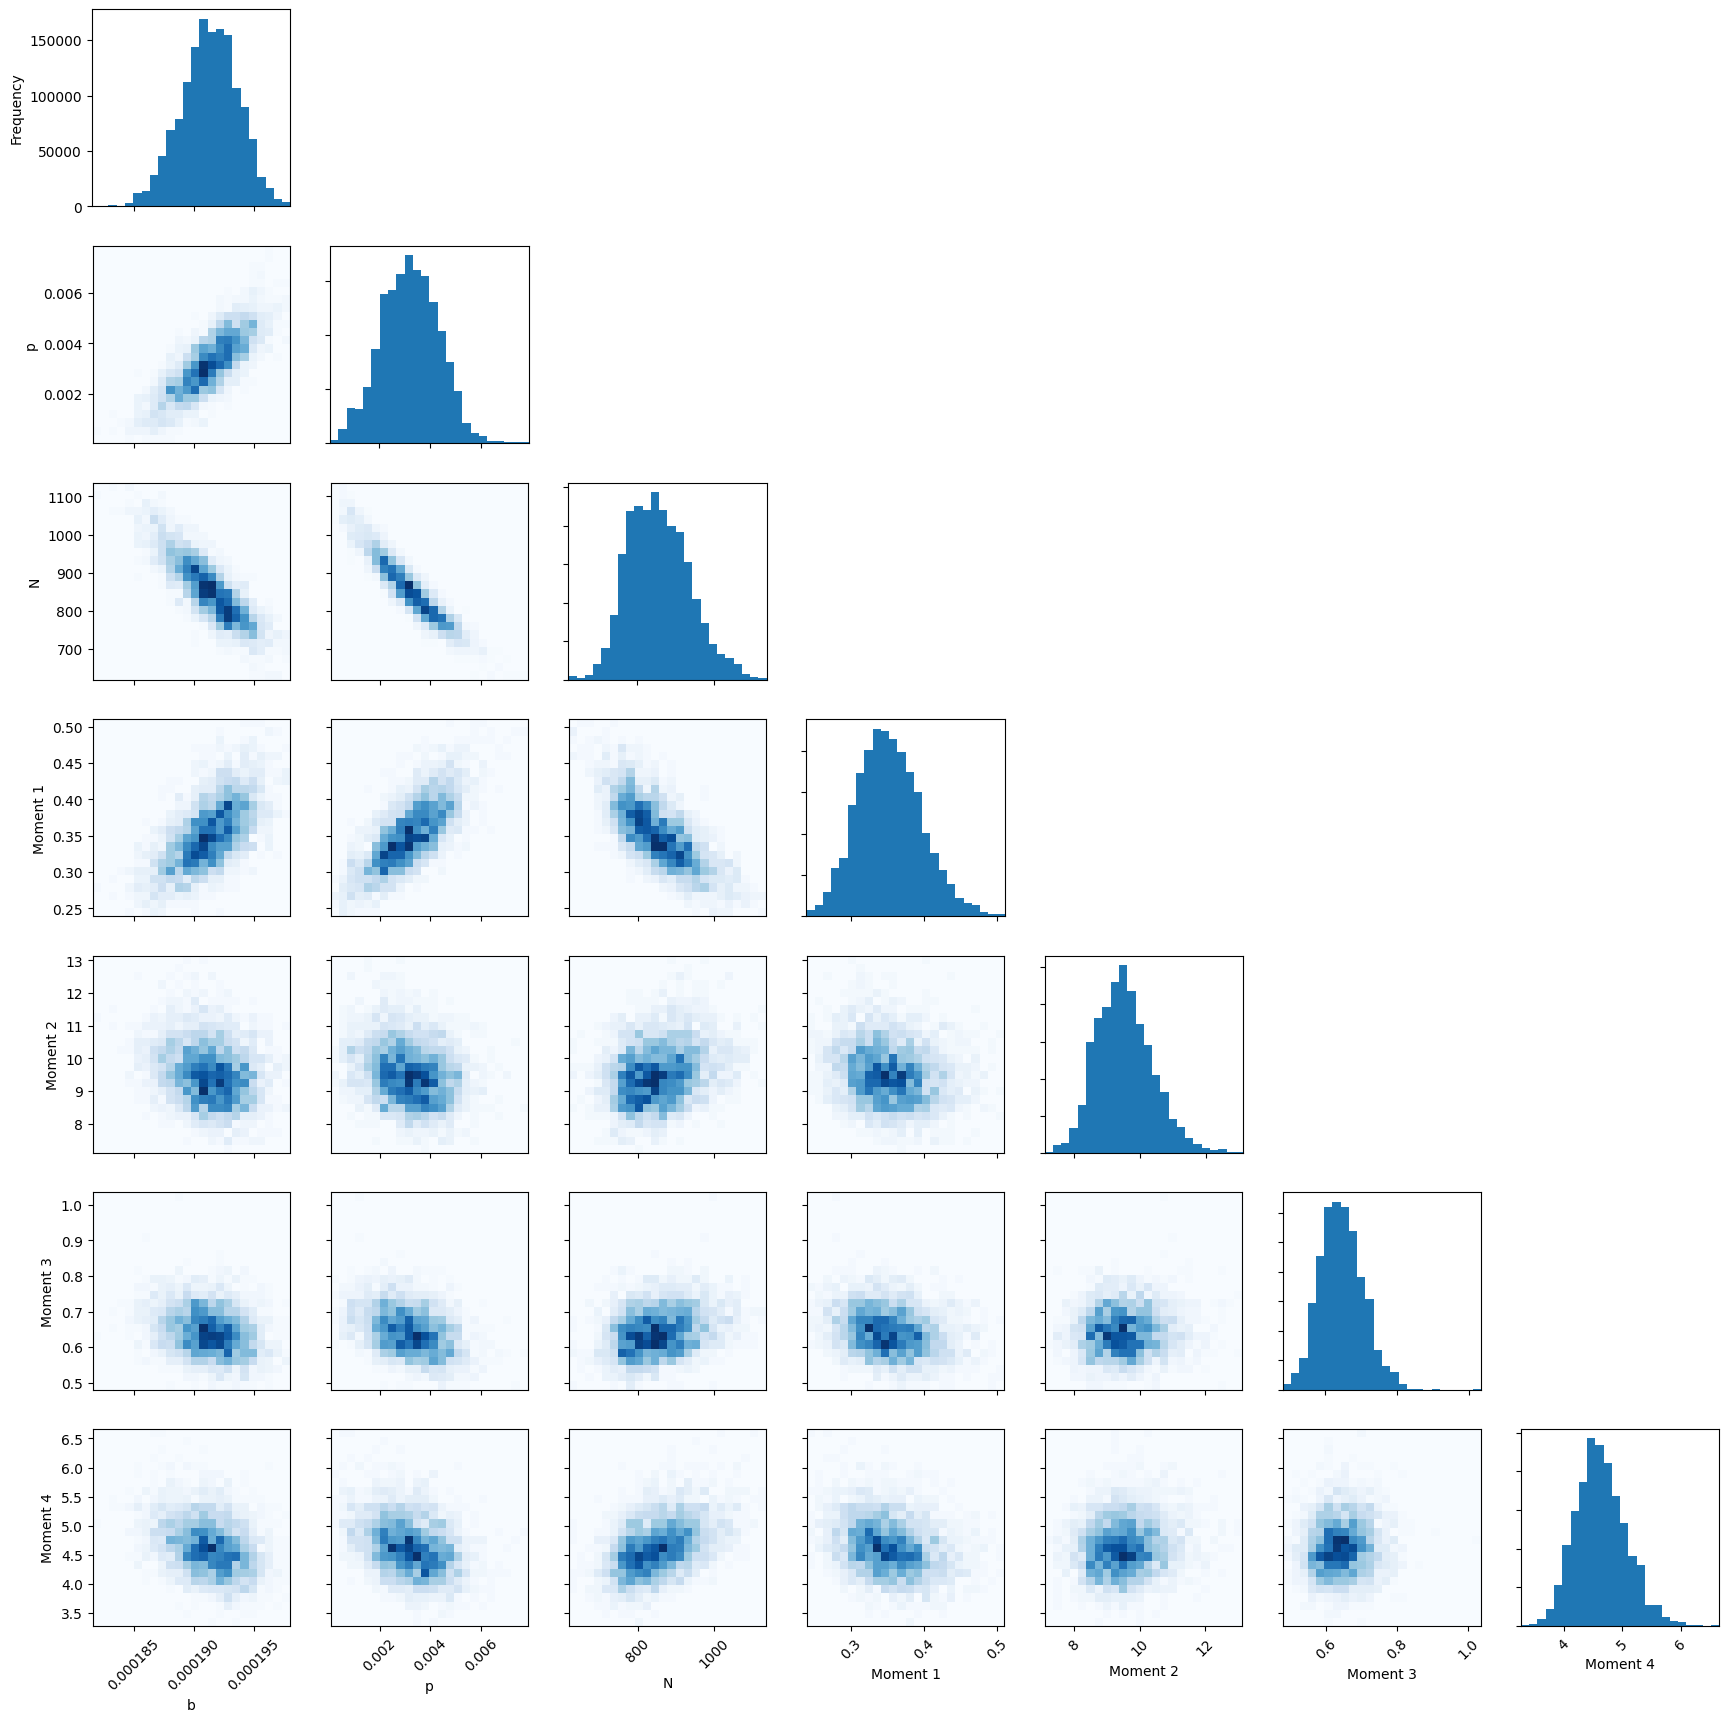

In [ ]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.savefig("Correct_pariwise_transfer.png", dpi=300, bbox_inches="tight")
plt.show()

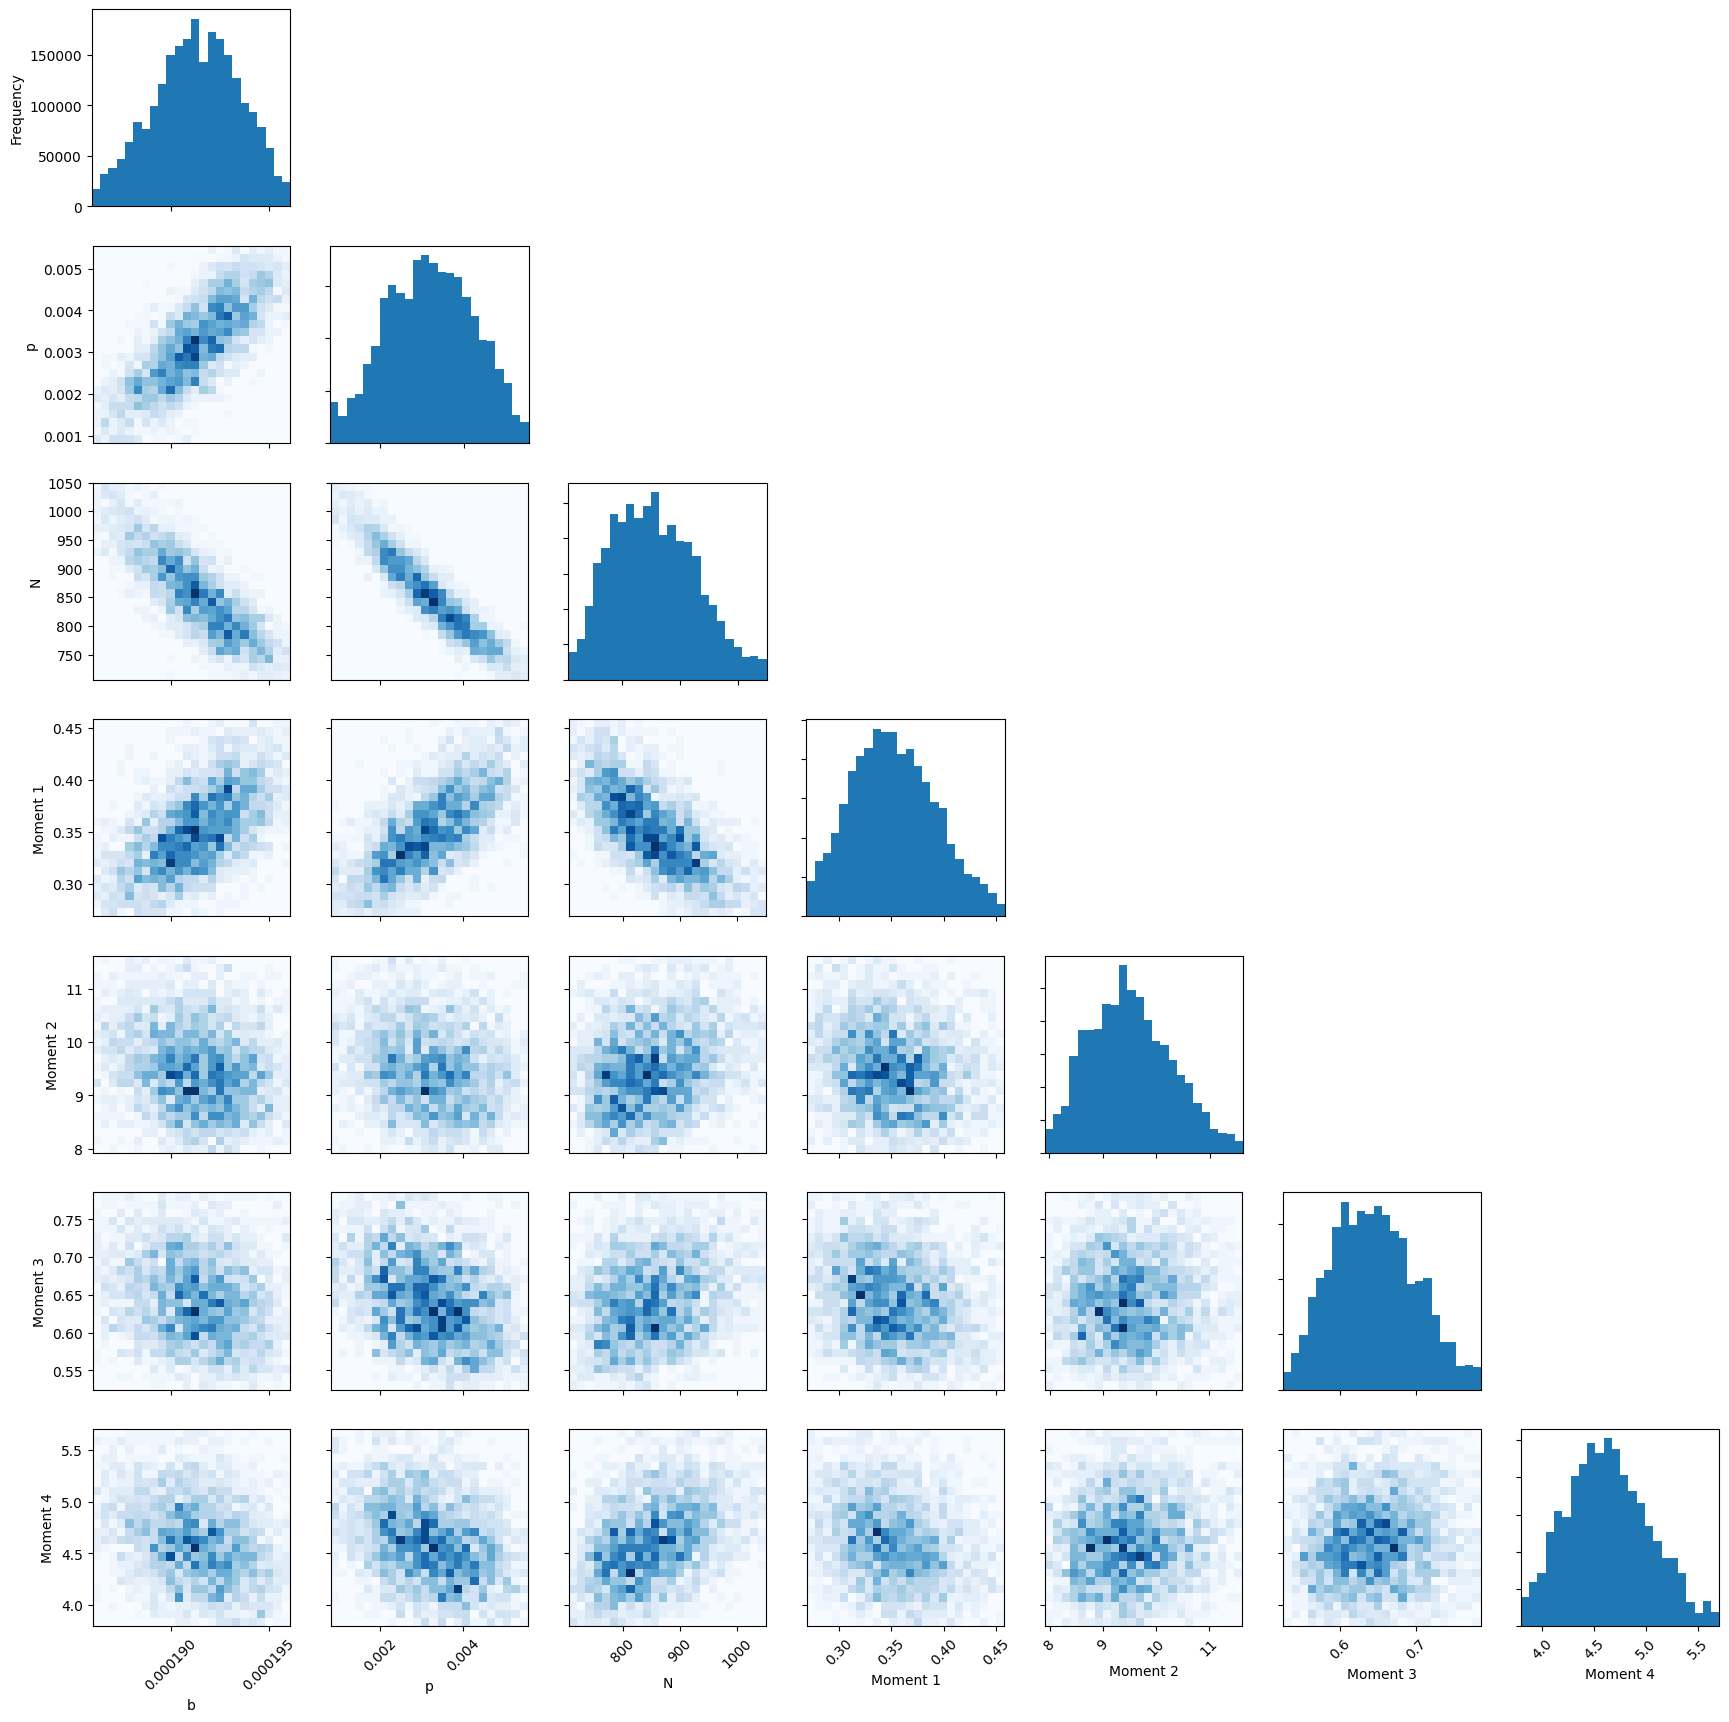

In [ ]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [ ]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    69.01   0.09
p         0.00    0.00    0.00    0.00    0.00    0.00    0.01     1.02    57.74   0.08
N         873.51  84.76   724.06  808.62  874.54  928.64  1052.03  1.02    56.40   0.08
Moment 1  0.35    0.04    0.27    0.31    0.34    0.37    0.44     1.02    83.83   0.11
Moment 2  9.60    0.88    8.07    9.01    9.52    10.16   11.53    1.00    398.77  0.53
Moment 3  0.65    0.06    0.55    0.60    0.65    0.69    0.78     1.00    366.11  0.49
Moment 4  4.67    0.45    3.90    4.36    4.64    4.95    5.62     1.01    210.49  0.28


In [ ]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [ ]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000191  2.49e-06  0.000186  0.000189  0.000191  0.000193  0.000196  1.02    69     0.0924
p         0.00296   0.00116   0.000819  0.00215   0.00285   0.0038    0.00523   1.02    57.7   0.0773
N         874       84.8      724       809       875       929       1.05e+03  1.02    56.4   0.0755
Moment 1  0.346     0.0441    0.269     0.314     0.341     0.374     0.442     1.02    83.8   0.112
Moment 2  9.6       0.88      8.07      9.01      9.52      10.2      11.5      1       399    0.534
Moment 3  0.65      0.0613    0.546     0.605     0.647     0.691     0.78      1       366    0.49
Moment 4  4.67      0.446     3.9       4.36      4.64      4.95      5.62      1.01    210    0.282


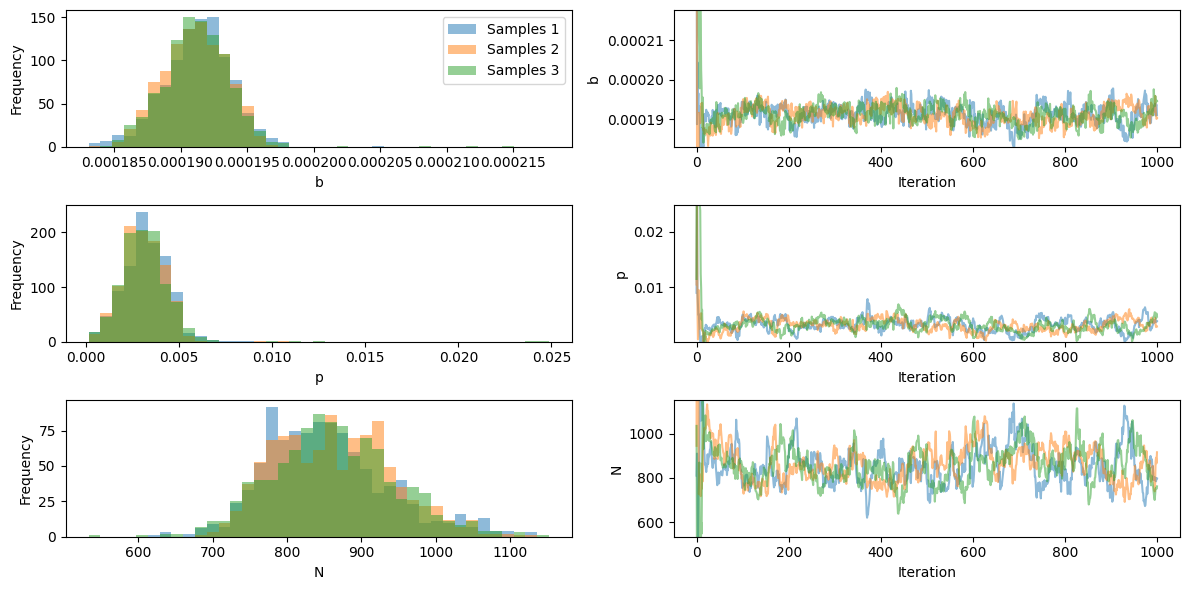

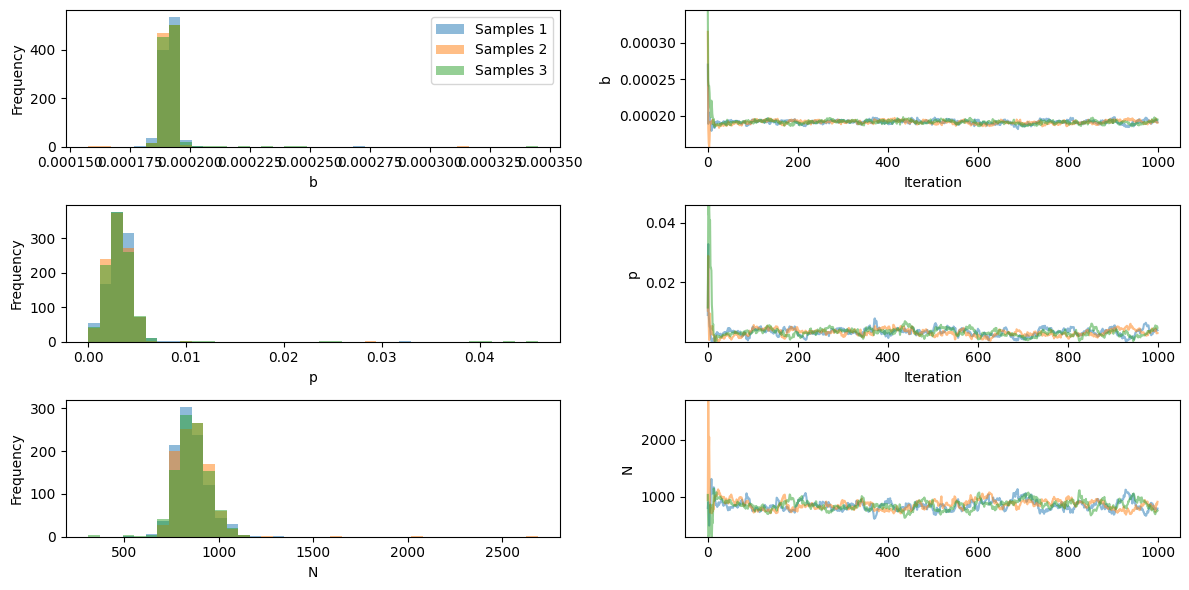

In [ ]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

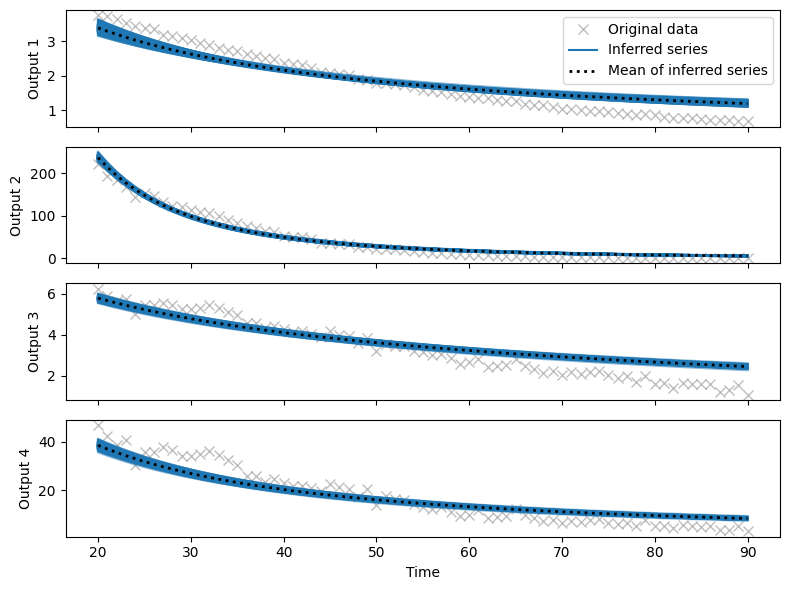

In [ ]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

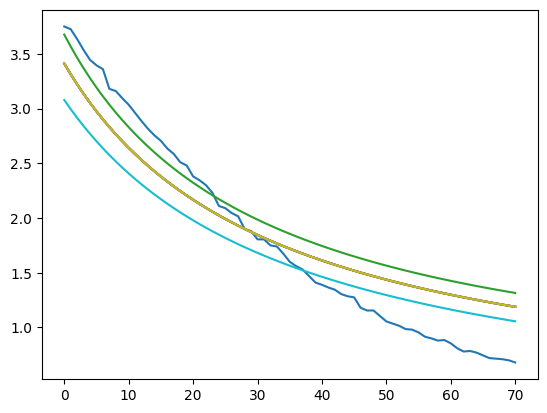

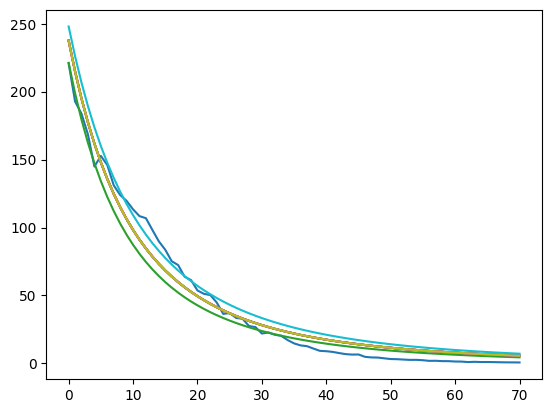

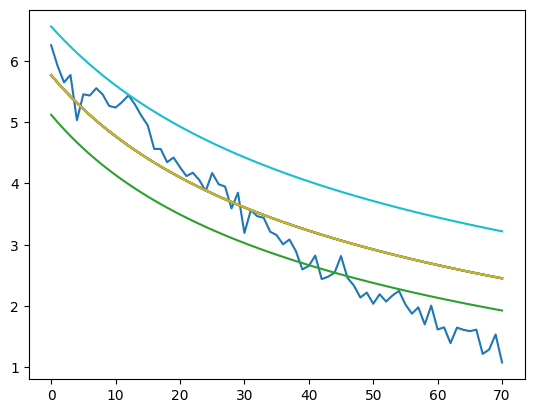

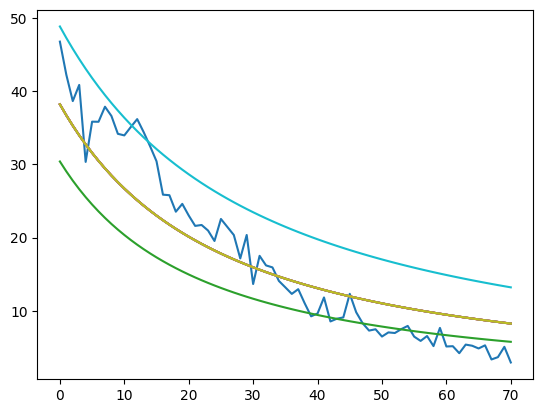

In [ ]:



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] += 2*st_devs[1] 
CI_2[2] -= 2*st_devs[2]

CI_3 = means
CI_3[0] += 2*st_devs[0]
CI_3[1] -= 2*st_devs[1] 
CI_3[2] += 2*st_devs[2]

CI_4 = means
CI_4[0] -= 2*st_devs[0]
CI_4[1] += 2*st_devs[1] 
CI_4[2] += 2*st_devs[2]

CI_5 = means
CI_5[0] += 2*st_devs[0]
CI_5[1] -= 2*st_devs[1] 
CI_5[2] -= 2*st_devs[2]

CI_6 = means
CI_6[0] -= 2*st_devs[0]
CI_6[1] += 2*st_devs[1] 
CI_6[2] -= 2*st_devs[2]

CI_7 = means
CI_7[0] -= 2*st_devs[0]
CI_7[1] -= 2*st_devs[1] 
CI_7[2] += 2*st_devs[2] 

CI_8 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
values_5 = model.simulate(CI_5, times)
values_6 = model.simulate(CI_6, times)
values_7 = model.simulate(CI_7, times)
values_8 = model.simulate(CI_8, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.plot(values_5[:,0])
plt.plot(values_6[:,0])
plt.plot(values_7[:,0])
plt.plot(values_8[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.plot(values_5[:,1])
plt.plot(values_6[:,1])
plt.plot(values_7[:,1])
plt.plot(values_8[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.plot(values_5[:,2])
plt.plot(values_6[:,2])
plt.plot(values_7[:,2])
plt.plot(values_8[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.plot(values_5[:,3])
plt.plot(values_6[:,3])
plt.plot(values_7[:,3])
plt.plot(values_8[:,3])
plt.show()

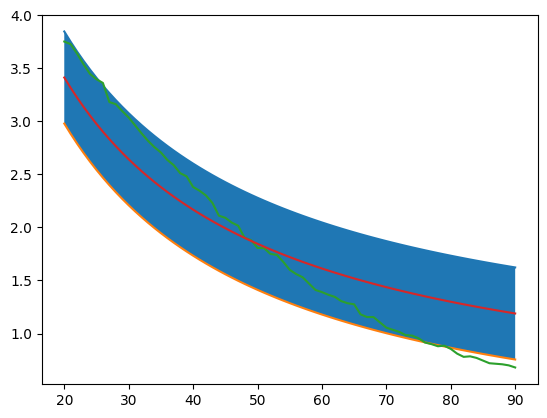

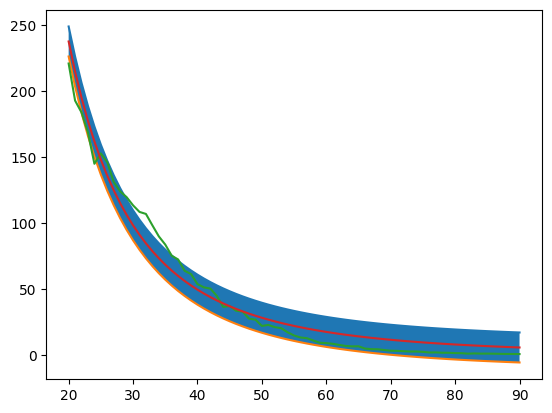

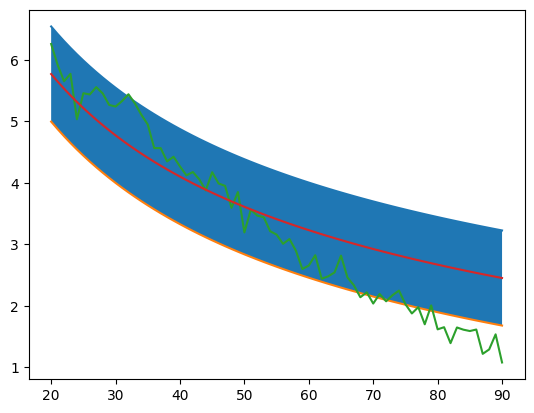

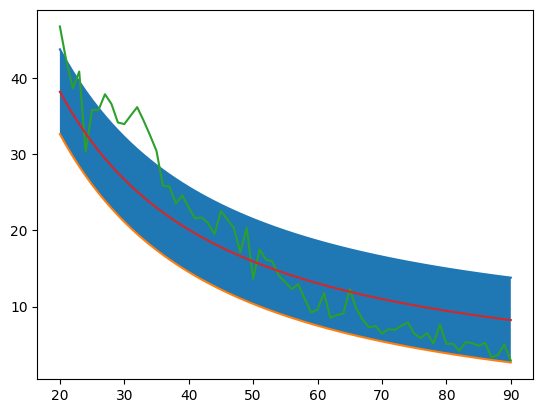

In [ ]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

mean_CI = results.mean()[[3,4,5,6]]
st_devs_CI = results.std()[[3,4,5,6]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,90,71)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
